Since we have added the 'genetic risk' feature to the young age group dataset (i.e., 'premiums_young.csv'), but lack 'genetic risk' information for the 'premiums_rest.csv' dataset, we will create a dummy column with a default value for 'genetic risk' in the 'premiums_rest.csv' dataset.

This step is necessary to maintain consistency in production, as the model for the young age group has been trained with the 'genetic risk' feature.

### **Import necessary libraries**

In [9]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from joblib import dump

In [10]:
df = pd.read_csv('../data/segmented_data/premiums_rest.csv')
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610


In [11]:
df['Genetical_Risk'] = 0

In [12]:
df.shape

(29904, 14)

In [13]:
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,0
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,0
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,0


### **Treat NA values**

In [14]:
df.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           9
employment_status        1
income_level             9
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

Here, we can see some NA values. However, since the number of such rows is very small compared to the total number of rows, we can drop them.

In [15]:
df.dropna(inplace=True)
df.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

### **Check for row-level duplicacy**

In [16]:
df.duplicated().sum()

0

In [17]:
df.drop_duplicates(inplace=True) # Added to treat row level duplicacy (if occur in future, if this data set change/new dataset come)
df.duplicated().sum()

0

### **Exploratory data analysis (EDA) and data cleaning**

In [18]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,29886.000000,29886.000000,29886.000000,29886.000000,29886.0
mean,43.396105,2.379910,23.364184,20892.303821,0.0
std,13.412657,1.431201,24.740339,6936.813440,0.0
min,26.000000,-3.000000,1.000000,3625.000000,0.0
25%,34.000000,1.000000,7.000000,15697.250000,0.0
50%,42.000000,3.000000,17.000000,20489.000000,0.0
75%,52.000000,3.000000,32.000000,26360.000000,0.0
max,356.000000,5.000000,930.000000,43471.000000,0.0


#### Univariate analysis: Numeric columns

In [19]:
columns_numeric = df.select_dtypes(include=['float64', 'int64']).columns
columns_numeric

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount',
       'genetical_risk'],
      dtype='object')

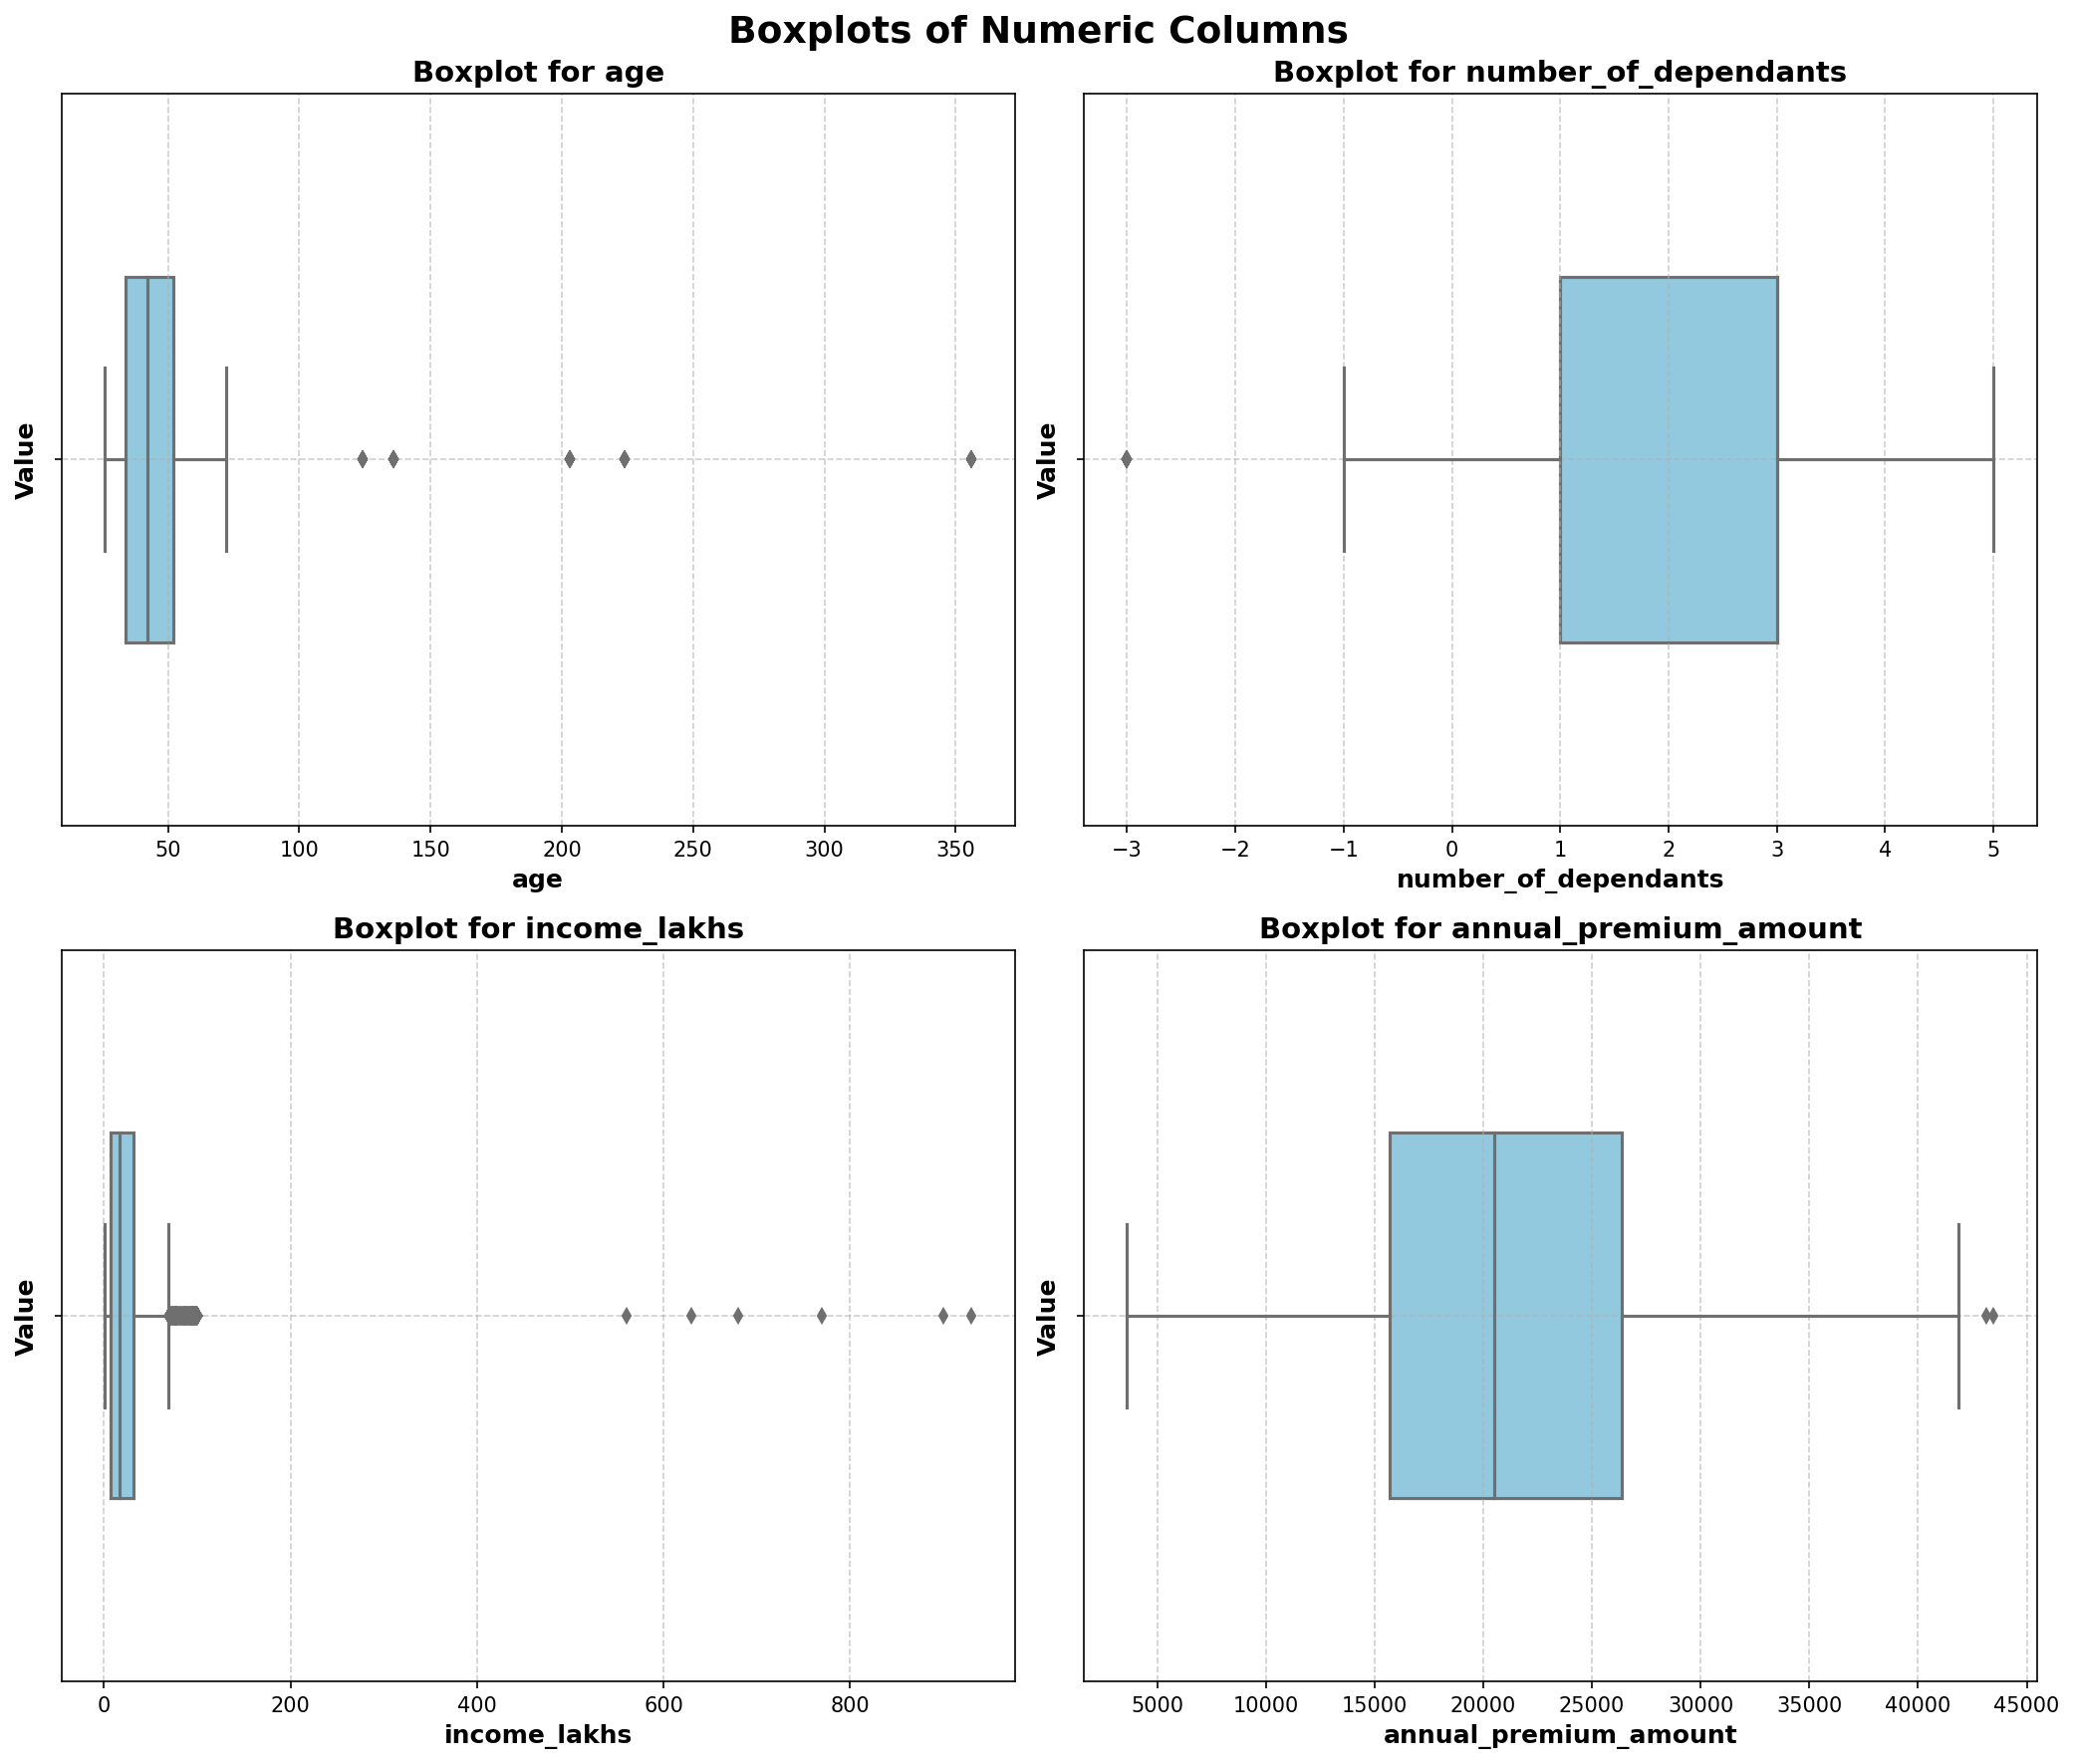

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12), dpi=150)
axes = axes.flatten()

for i, column in enumerate(columns_numeric[:4]):
    sns.boxplot(x=df[column], ax=axes[i], color='skyblue', width=0.5, linewidth=1.5)
    axes[i].set_title(f'Boxplot for {column}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel(column, fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Value', fontsize=12, fontweight='bold')
    axes[i].grid(True, linestyle='--', alpha=0.6)

fig.suptitle('Boxplots of Numeric Columns', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

#### Handling outliers: age column

In [21]:
df[df.age > 100].shape

(58, 14)

In [22]:
df[df.age > 100].age.unique()

array([224, 124, 136, 203, 356], dtype=int64)

In [23]:
df1 = df[df.age <= 100].copy()
df1.age.describe()

count    29828.000000
mean        43.095380
std         11.041991
min         26.000000
25%         34.000000
50%         42.000000
75%         52.000000
max         72.000000
Name: age, dtype: float64

#### Data cleaning: number_of_dependants

In [24]:
df1[df1.number_of_dependants < 0].number_of_dependants.unique()

array([-1, -3], dtype=int64)

In [25]:
df1.number_of_dependants = df1.number_of_dependants.abs()
df1.number_of_dependants.describe()

count    29828.000000
mean         2.387790
std          1.420641
min          0.000000
25%          1.000000
50%          3.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

#### Handling outliers: income column

In [26]:
def iqr_bounds(column):
    q1, q3 = column.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower_bound, upper_bound = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return lower_bound, upper_bound

In [27]:
lower, upper = iqr_bounds(df['income_lakhs'])
lower, upper

(-30.5, 69.5)

In [28]:
df1[df1['income_lakhs']>upper].shape

(2090, 14)

In [29]:
threshold = 0.999
quantile_with_threshold = df1['income_lakhs'].quantile(0.999)
quantile_with_threshold

100.0

In [30]:
df1[df1.income_lakhs > quantile_with_threshold].shape

(6, 14)

In [31]:
df2 = df1[df1.income_lakhs <= quantile_with_threshold].copy()
df2.shape

(29822, 14)

In [32]:
df2.income_lakhs.describe()

count    29822.000000
mean        23.226343
std         22.455408
min          1.000000
25%          7.000000
50%         17.000000
75%         32.000000
max        100.000000
Name: income_lakhs, dtype: float64

In [33]:
df2.annual_premium_amount.describe()

count    29822.000000
mean     20900.689223
std       6928.192115
min       6538.000000
25%      15705.250000
50%      20495.500000
75%      26360.000000
max      43471.000000
Name: annual_premium_amount, dtype: float64

The maximum value of 'annual_premium_amount' appears reasonable, so we'll leave it as it is.

#### Bivariate analysis: Numeric columns

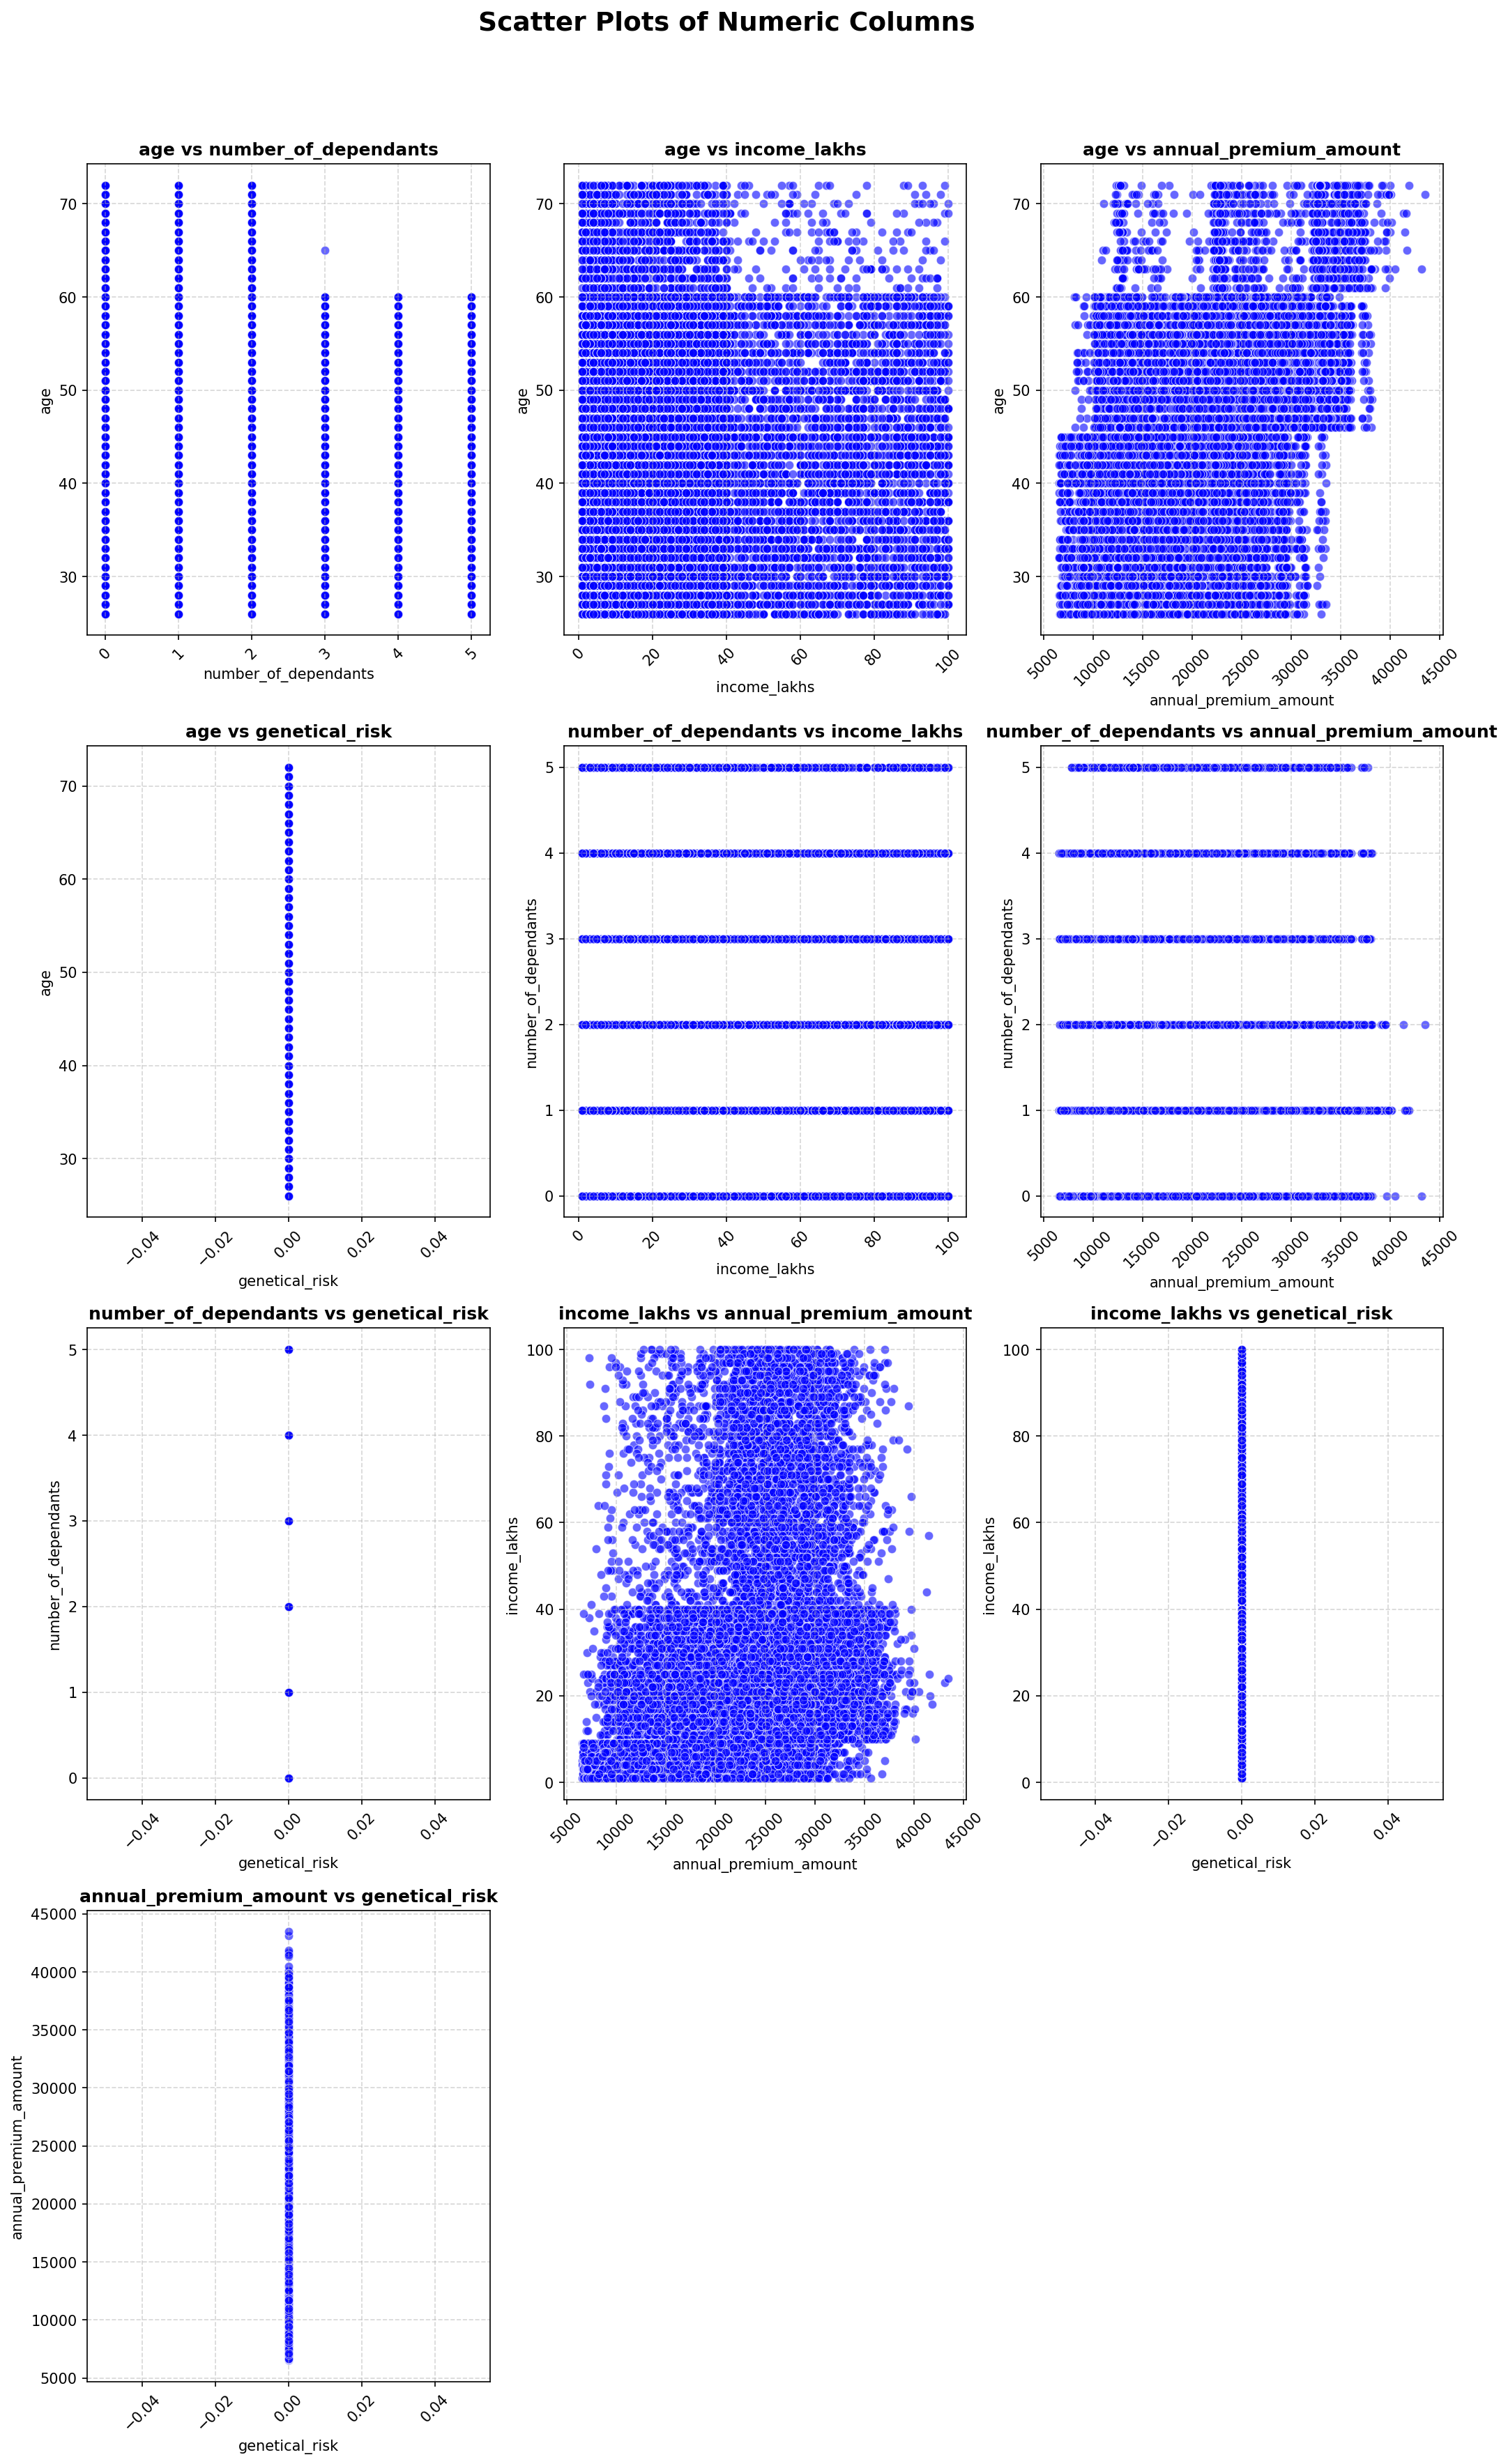

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

num_pairs = sum(range(len(columns_numeric)))
rows = (num_pairs // 3) + (num_pairs % 3 > 0)
cols = min(3, num_pairs)

fig, axes = plt.subplots(rows, cols, figsize=(14, rows * 6), dpi=150)
fig.suptitle('Scatter Plots of Numeric Columns', fontsize=18, fontweight='bold')

if rows == 1:
    axes = np.expand_dims(axes, axis=0)

plot_index = 0

for i, col_y in enumerate(columns_numeric):
    for col_x in columns_numeric[i+1:]:
        row, col = divmod(plot_index, 3)
        sns.scatterplot(x=df2[col_x], y=df2[col_y], ax=axes[row, col], color='blue', alpha=0.6)
        axes[row, col].set_title(f'{col_y} vs {col_x}', fontsize=12, fontweight='bold')
        axes[row, col].set_xlabel(col_x, fontsize=10)
        axes[row, col].set_ylabel(col_y, fontsize=10)
        axes[row, col].grid(True, linestyle='--', alpha=0.5)
        axes[row, col].tick_params(axis='x', rotation=45)
        plot_index += 1

for i in range(plot_index, rows * cols):
    row, col = divmod(i, 3)
    fig.delaxes(axes[row, col])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Here, we observe that as the genetic risk score has no effect on the annual premium amount, since it is a dummy feature.

#### Categorical columns

In [35]:
columns_categorical = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status', 'income_level', 'medical_history', 'insurance_plan']
for column in columns_categorical:
    print(column, ":", df2[column].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Does Not Smoke' 'Not Smoking'
 'Smoking=0']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


In [36]:
df2.smoking_status.replace({
    'Not Smoking': 'No Smoking',
    'Does Not Smoke': 'No Smoking',
    'Smoking=0': 'No Smoking'
}, inplace=True)

df2.smoking_status.unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

#### Univariate analysis

In [37]:
len(columns_categorical)

9

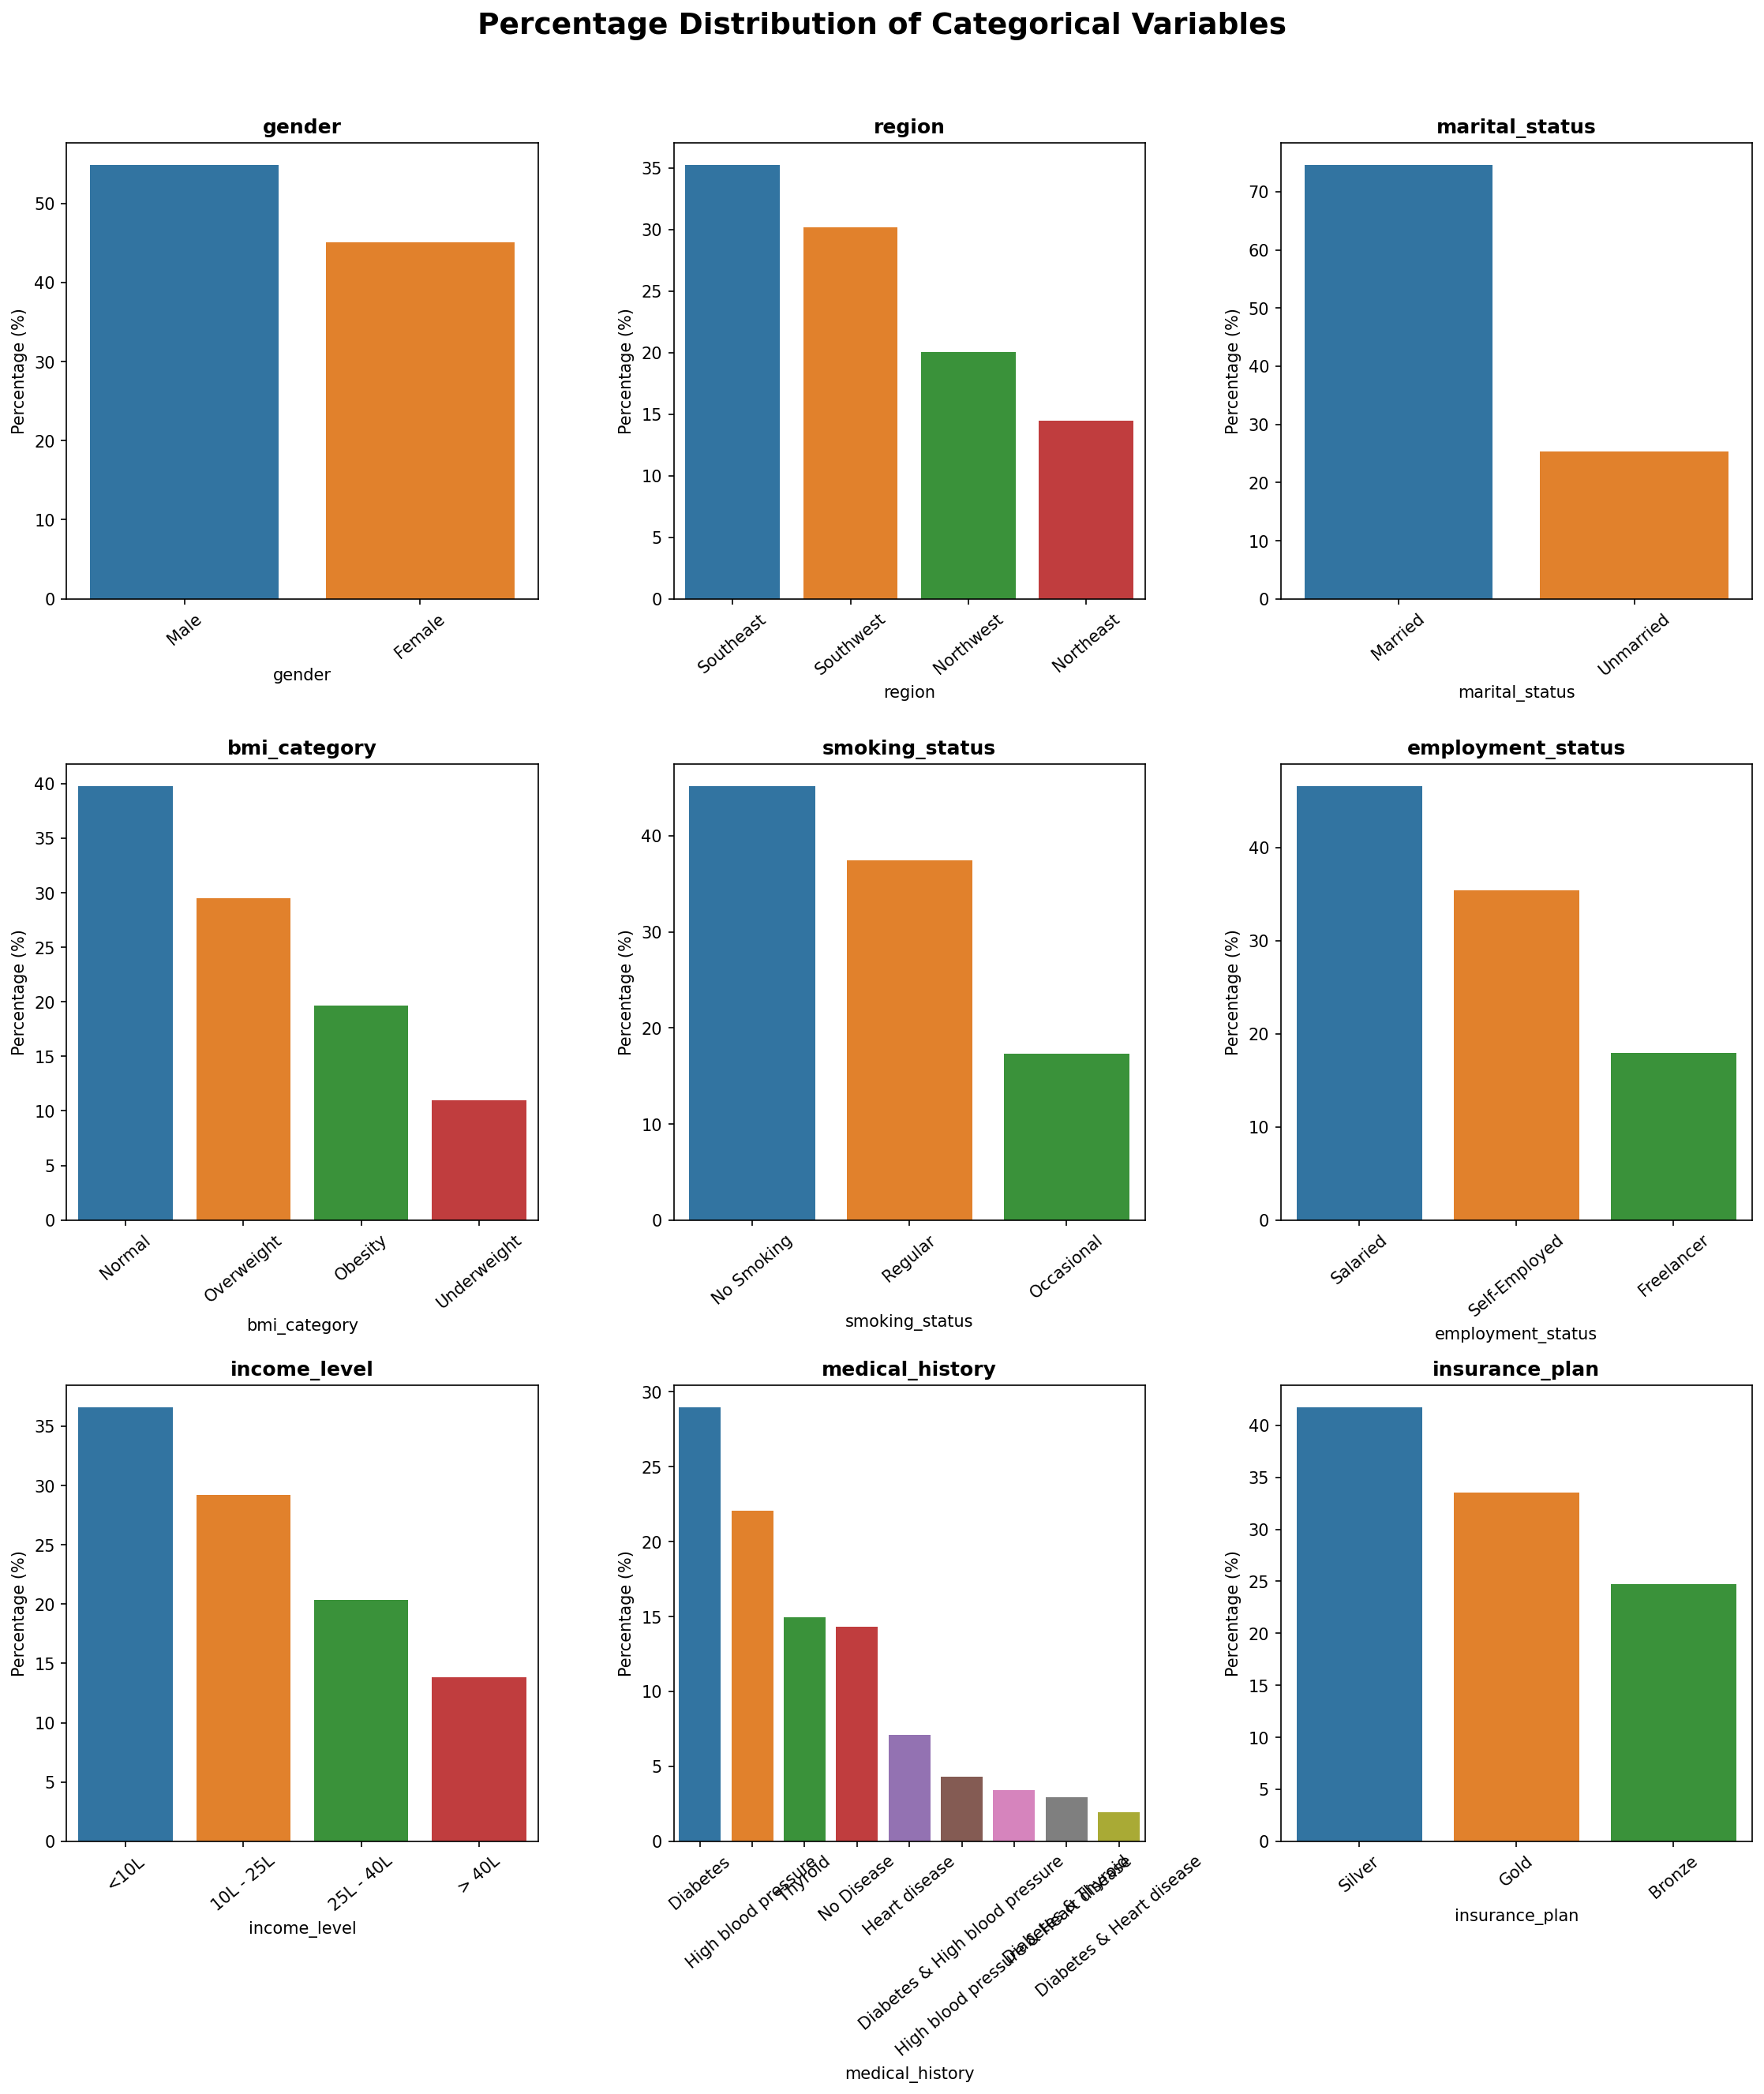

In [38]:
fig, axes = plt.subplots(3, 3, figsize=(15, 18), dpi=150)
fig.suptitle("Percentage Distribution of Categorical Variables", fontsize=18, fontweight='bold')

axes = axes.flatten()

for i, column in enumerate(columns_categorical):
    count_pct = df2[column].value_counts(normalize=True) * 100
    sns.barplot(x=count_pct.index, y=count_pct.values, ax=axes[i])
    axes[i].set_title(f'{column}', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Percentage (%)')
    axes[i].set_xlabel(column)
    axes[i].tick_params(axis='x', rotation=40)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Bivariate analysis

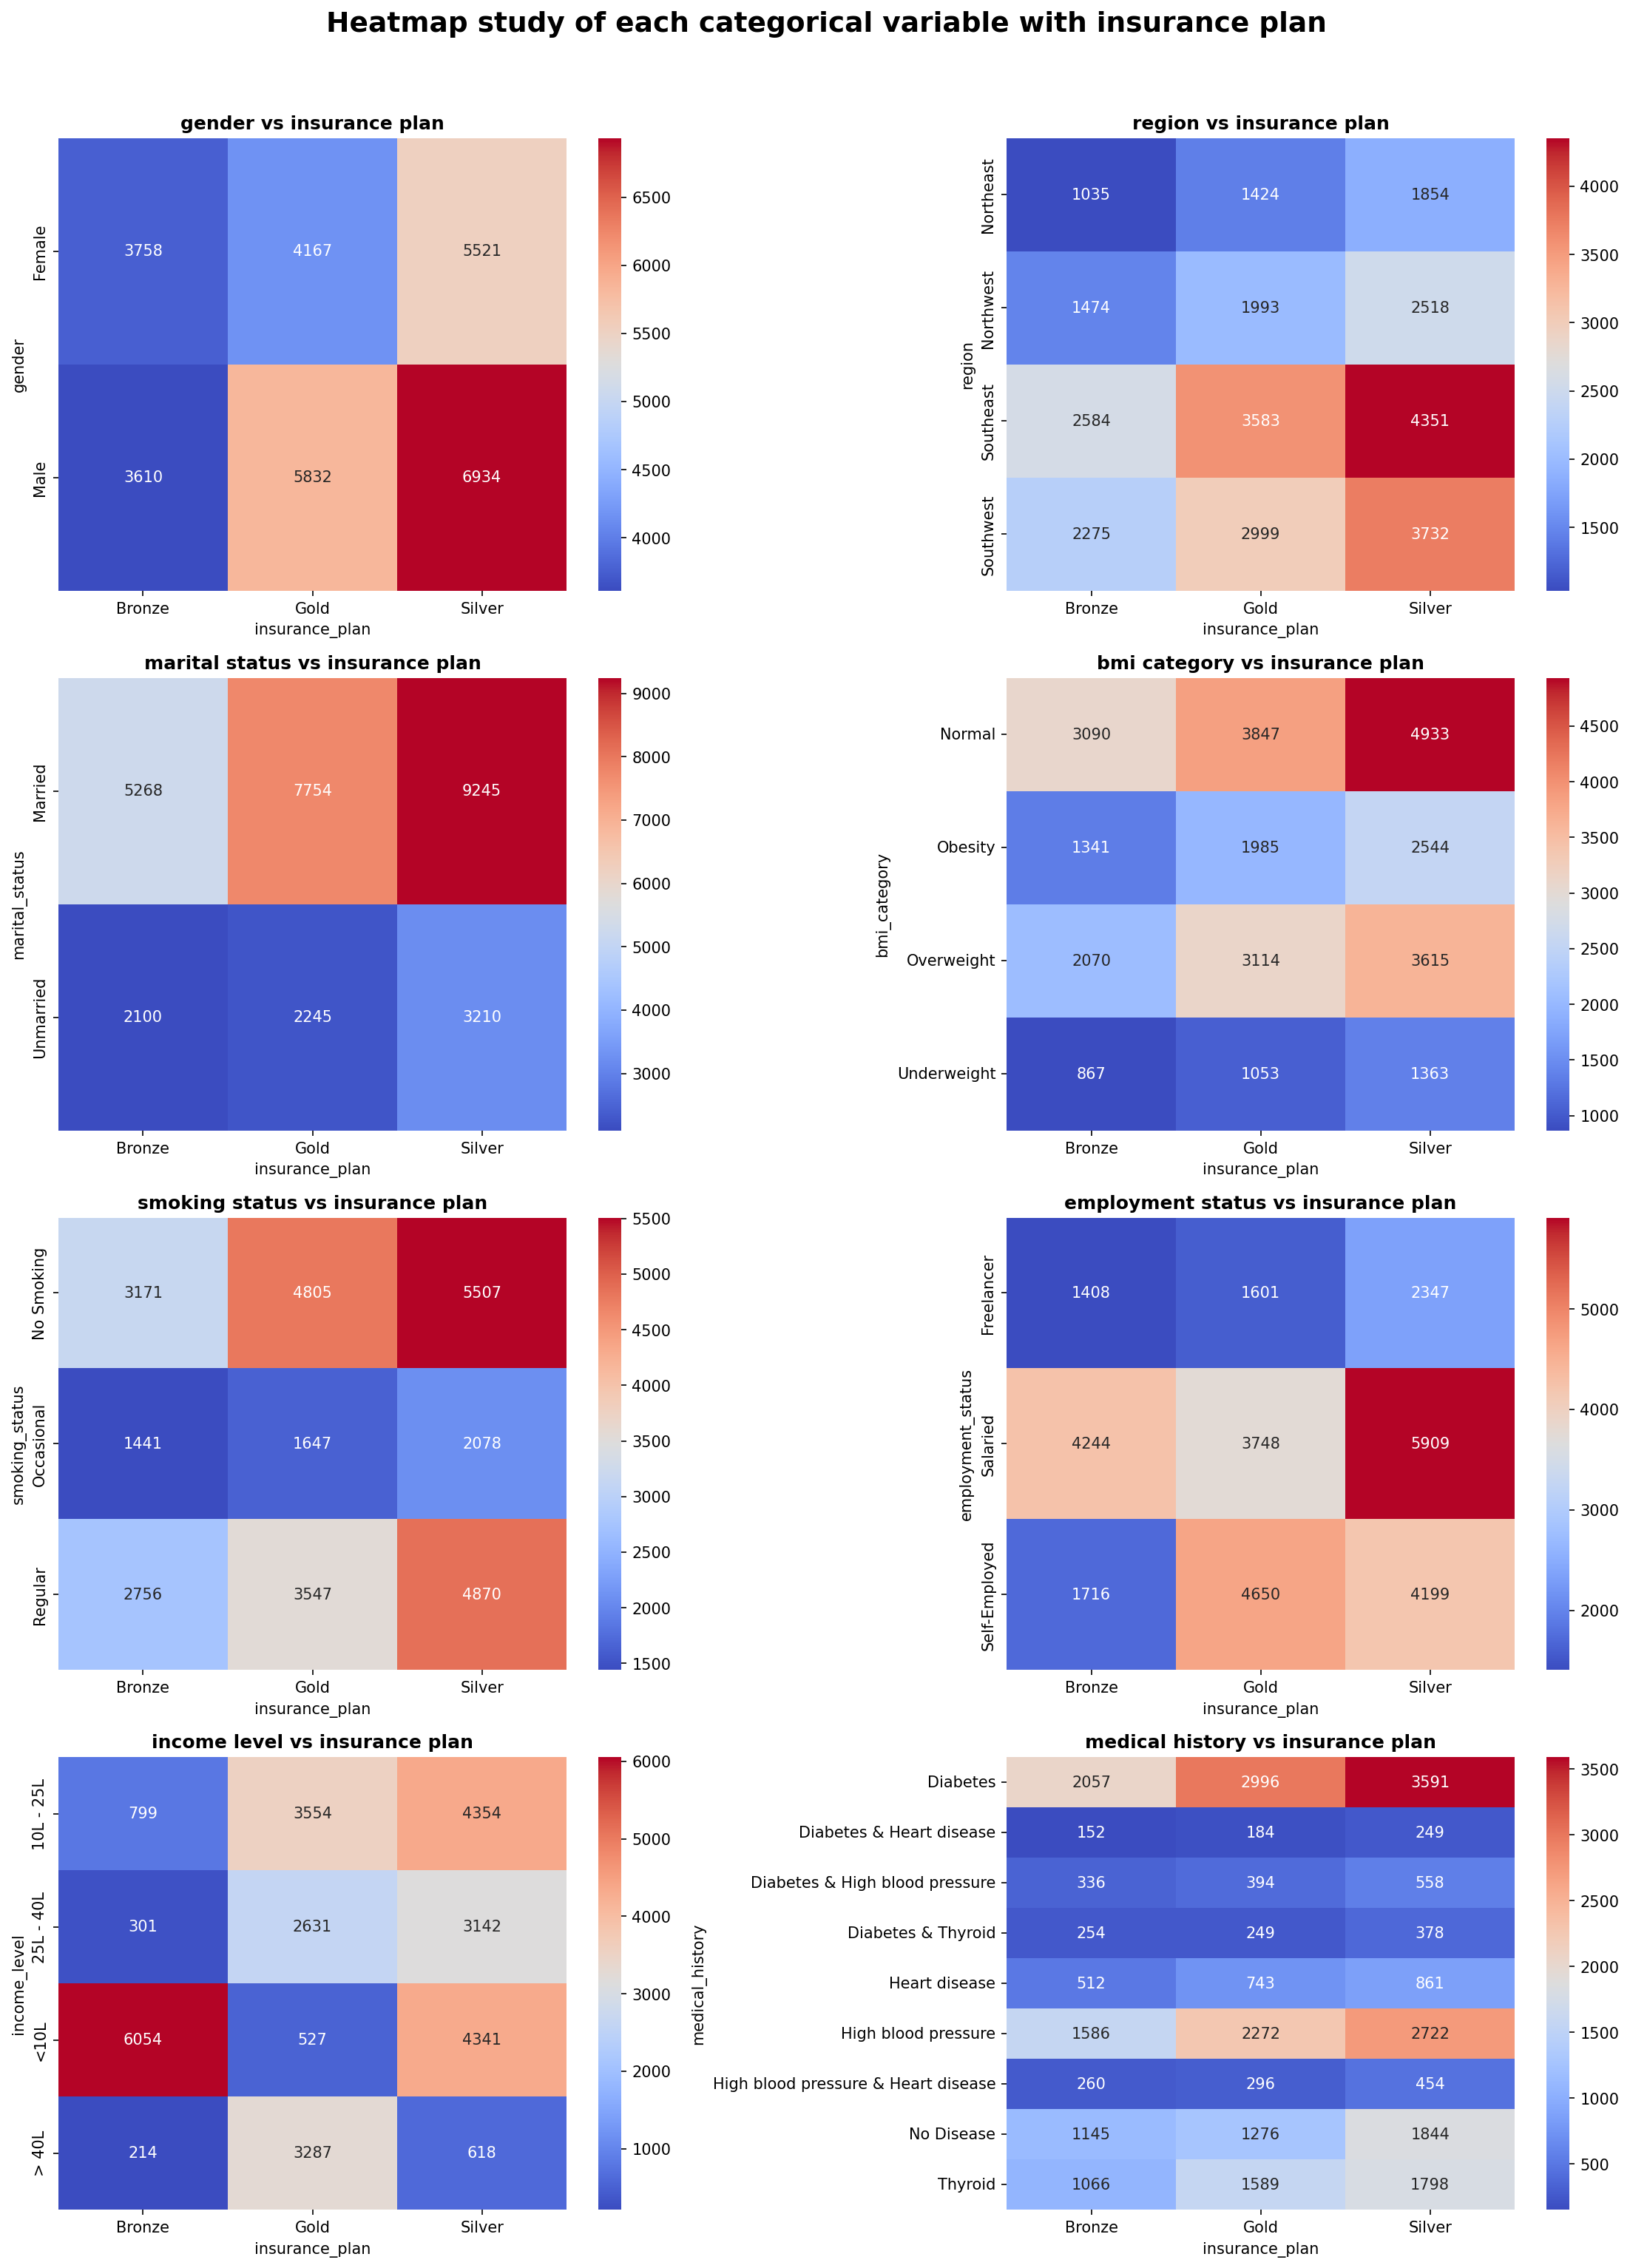

In [39]:
fig, axes = plt.subplots(4, 2, figsize=(15, 20), dpi=150)
fig.suptitle("Heatmap study of each categorical variable with insurance plan", fontsize=18, fontweight='bold', y=1.02)

axes = axes.flatten()  

for i, column in enumerate(columns_categorical):
    crosstab = pd.crosstab(df2[column], df2['insurance_plan'])
    try:
        sns.heatmap(crosstab, annot=True, cmap='coolwarm', fmt="d", ax=axes[i])
        axes[i].set_title(f'{column.replace("_", " ")} vs insurance plan', fontsize=12, fontweight='bold')
    except:
        pass
    

plt.tight_layout()
plt.show()

### **Feature Engineering**

In [40]:
# Manually assign risk scores for each condition
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}

df2[['disease1', 'disease2']] = df2.medical_history.str.split(" & ", expand = True).apply(lambda x: x.str.lower())

In [41]:
df2.isna().sum()

age                          0
gender                       0
region                       0
marital_status               0
number_of_dependants         0
bmi_category                 0
smoking_status               0
employment_status            0
income_level                 0
income_lakhs                 0
medical_history              0
insurance_plan               0
annual_premium_amount        0
genetical_risk               0
disease1                     0
disease2                 26058
dtype: int64

In [42]:
df2['disease2'].fillna('none', inplace=True)

In [43]:
df2.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
disease1                 0
disease2                 0
dtype: int64

In [44]:
df2['total_risk_score'] = 0

In [45]:
for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

In [46]:
# Normalizing the risk score to a range of 0 to 1
max_score = df2.total_risk_score.max()
min_score = df2.total_risk_score.min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score)/(max_score - min_score)
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,0,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,0,no disease,none,0,0.000000
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,0,diabetes,none,6,0.428571


#### Encode text columns

In [47]:
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})

In [48]:
df2.income_level.unique()

array(['<10L', '10L - 25L', '> 40L', '25L - 40L'], dtype=object)

In [49]:
df2['income_level'] = df2['income_level'].map({'<10L':1, '10L - 25L': 2, '25L - 40L':3, '> 40L':4})
columns_nominal = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df3 = pd.get_dummies(df2, columns=columns_nominal, drop_first=True, dtype=int)
df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,0,diabetes,none,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,0,diabetes,none,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,0,high blood pressure,none,...,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,No Disease,3,20303,0,no disease,none,...,1,0,0,0,0,0,0,0,1,0
4,56,3,2,14,Diabetes,1,15610,0,diabetes,none,...,0,0,0,1,0,0,1,0,0,1


In [50]:
df3.shape

(29822, 24)

In [51]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29822 entries, 0 to 29903
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              29822 non-null  int64  
 1   number_of_dependants             29822 non-null  int64  
 2   income_level                     29822 non-null  int64  
 3   income_lakhs                     29822 non-null  int64  
 4   medical_history                  29822 non-null  object 
 5   insurance_plan                   29822 non-null  int64  
 6   annual_premium_amount            29822 non-null  int64  
 7   genetical_risk                   29822 non-null  int64  
 8   disease1                         29822 non-null  object 
 9   disease2                         29822 non-null  object 
 10  total_risk_score                 29822 non-null  int64  
 11  normalized_risk_score            29822 non-null  float64
 12  gender_Male       

#### Feature selection

In [52]:
df4 = df3.drop(['medical_history','disease1', 'disease2', 'total_risk_score'], axis=1)
df4.head()                

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,3,20303,0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,56,3,2,14,1,15610,0,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


#### Calculating the Variance Inflation Factor (VIF) to detect multicollinearity

In [53]:
df4.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'insurance_plan', 'annual_premium_amount', 'genetical_risk',
       'normalized_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

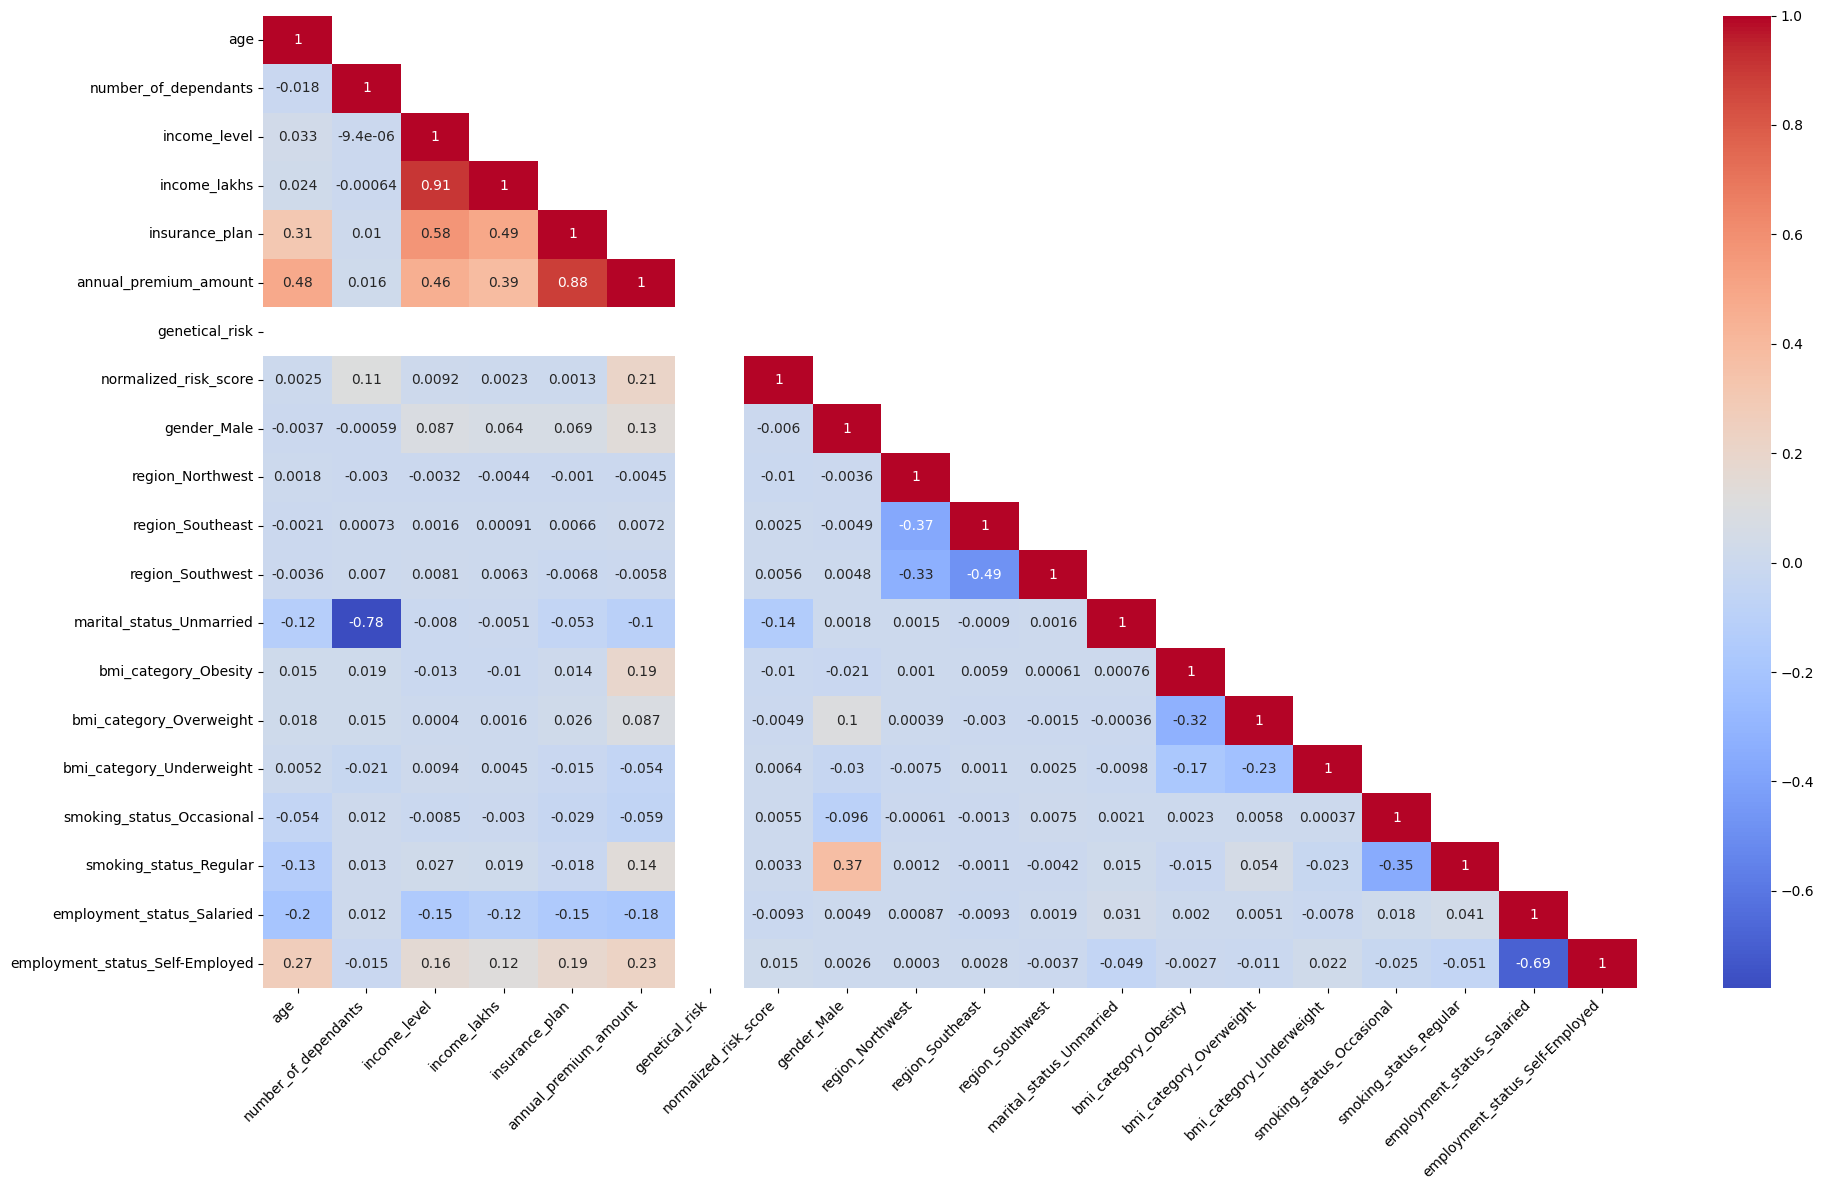

In [54]:
conf_matrix = df4.corr()

mask = np.triu(np.ones_like(conf_matrix, dtype=bool), k=1)

plt.figure(figsize=(20, 12))
sns.heatmap(conf_matrix, annot=True, mask=mask, cmap='coolwarm')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Here, we can see that 'genetic risk' doesn't have any correlation with other variables, as it is just a dummy variable.

In [55]:
X = df4.drop('annual_premium_amount', axis='columns')
y = df4['annual_premium_amount']

cols_to_scale = ['age','number_of_dependants', 'income_level',  'income_lakhs', 'insurance_plan', 'genetical_risk']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.0,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000
mean,0.371628,0.477547,0.371225,0.224509,0.544112,0.0,0.426373,0.549125,0.200691,0.352693,0.301992,0.253336,0.196835,0.295051,0.110087,0.173228,0.374656,0.466132,0.354269
std,0.240053,0.284129,0.351111,0.226822,0.379009,0.0,0.240084,0.497589,0.400524,0.477816,0.459129,0.434929,0.397613,0.456073,0.313003,0.378450,0.484042,0.498860,0.478299
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.173913,0.200000,0.000000,0.060606,0.500000,0.0,0.357143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.347826,0.600000,0.333333,0.161616,0.500000,0.0,0.428571,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.565217,0.600000,0.666667,0.313131,1.000000,0.0,0.428571,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [56]:
def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

calculate_vif(X)

c:\Users\rajat\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


,Column,VIF
0,age,3.921783
1,number_of_dependants,6.278938
2,income_level,13.890522
3,income_lakhs,11.185596
4,insurance_plan,5.271297
5,genetical_risk,NaN
6,normalized_risk_score,3.810619
7,gender_Male,2.599098
8,region_Northwest,2.123965
9,region_Southeast,2.980842


In [57]:
calculate_vif(X.drop('income_level', axis="columns"))

c:\Users\rajat\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


,Column,VIF
0,age,3.863055
1,number_of_dependants,6.278147
2,income_lakhs,2.678102
3,insurance_plan,4.574625
4,genetical_risk,NaN
5,normalized_risk_score,3.808345
6,gender_Male,2.591439
7,region_Northwest,2.123277
8,region_Southeast,2.979899
9,region_Southwest,2.708641


In [58]:
X_reduced = X.drop('income_level', axis="columns")

### **Train the model**

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.30, random_state=10)
print(f"x train: {X_train.shape}\nx test: {X_test.shape}\ny train: {y_train.shape}\ny test: {y_test.shape}")

x train: (20875, 18)
x test: (8947, 18)
y train: (20875,)
y test: (8947,)


#### Linear regression

In [60]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score = model_lr.score(X_train, y_train)
train_score, test_score

(0.9534163989489616, 0.9538448451629948)

In [61]:
y_pred = model_lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print(f"MSE: {mse_lr}\nRMSE: {rmse_lr}")

MSE: 2183844.360312456
RMSE: 1477.7835972538253


In [62]:
np.set_printoptions(suppress=True, precision=6)
model_lr.coef_

array([ 7016.239328, -1311.764702,  -708.193369, 14835.988208,
           0.      ,  6053.624123,    37.558269,   -55.250872,
         -19.622543,   -22.289676,  -700.3202  ,  3926.812706,
        1979.456047,   612.866236,   837.395101,  2800.661843,
         -45.491367,   243.078421])

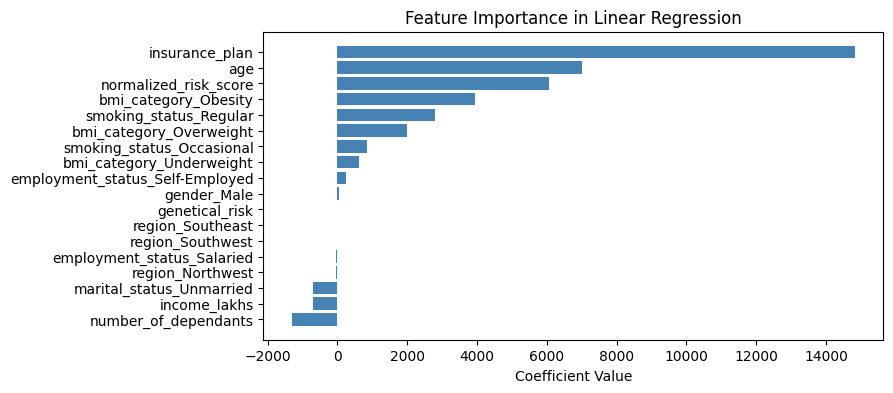

In [63]:
feature_importance = model_lr.coef_

coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

#### Ridge regression

In [64]:
model_rg = Ridge(alpha=1)
model_rg.fit(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
train_score = model_rg.score(X_train, y_train)
train_score, test_score

(0.9534162332209687, 0.9538456995663842)

In [65]:
y_pred = model_rg.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print(f"MSE: {mse_lr}\nRMSE: {rmse_lr}")

MSE: 2183803.9339715634
RMSE: 1477.769919159124


#### XGBoost

In [66]:
model_xgb = XGBRegressor(n_estimators=20, max_depth=3)
model_xgb.fit(X_train, y_train)
model_xgb.score(X_test, y_test)

0.9948463218448139

In [67]:
y_pred = model_xgb.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print(f"MSE: {mse_lr}\nRMSE: {rmse_lr}")

MSE: 243847.75685001153
RMSE: 493.8094337393845


In [68]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
random_search.best_score_

0.9970577807993951

In [69]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}

In [70]:
best_model = random_search.best_estimator_

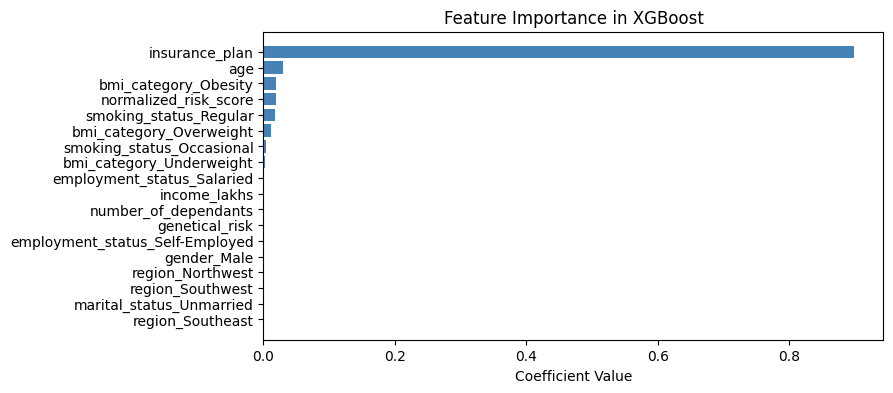

In [71]:
feature_importance = best_model.feature_importances_

coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

In [72]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = (residuals / y_test) * 100

results_df = pd.DataFrame({
    'actual': y_test, 
    'predicted': y_pred, 
    'diff': residuals, 
    'diff_pct': residuals_pct
})
results_df.head()

,actual,predicted,diff,diff_pct
19713,26895,26691.470703,-203.529297,-0.756755
14750,22734,22650.751953,-83.248047,-0.366183
19932,21198,21581.894531,383.894531,1.810994
29643,9100,9425.934570,325.934570,3.581699
17076,26434,26691.470703,257.470703,0.974013


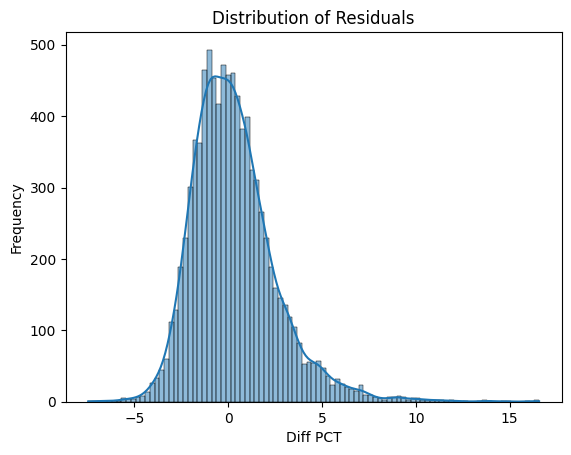

In [73]:
sns.histplot(results_df['diff_pct'], kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Diff PCT')
plt.ylabel('Frequency')
plt.show()

### **Error analysis**

In [74]:
extreme_error_threshold = 10
extreme_results_df = results_df[np.abs(results_df['diff_pct']) > extreme_error_threshold]
extreme_results_df.head()

,actual,predicted,diff,diff_pct
14286,6845,7621.263672,776.263672,11.340594
27518,8502,9425.934570,923.934570,10.867261
9285,6872,7621.263672,749.263672,10.903138
7547,6538,7621.263672,1083.263672,16.568732
21910,6651,7621.263672,970.263672,14.588237


In [75]:
extreme_results_df.shape

(29, 4)

In [76]:
extreme_errors_pct = extreme_results_df.shape[0]*100/X_test.shape[0]
extreme_errors_pct

0.32413099362914943

In [77]:
dump(best_model, "../artifacts/model_rest.joblib")

scaler_with_cols = {
    'scaler': scaler,
    'cols_to_scale': cols_to_scale
}

dump(scaler_with_cols, "../artifacts/scaler_rest.joblib")

['../artifacts/scaler_rest.joblib']